In [1]:
import torch
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import ujson as json
import math

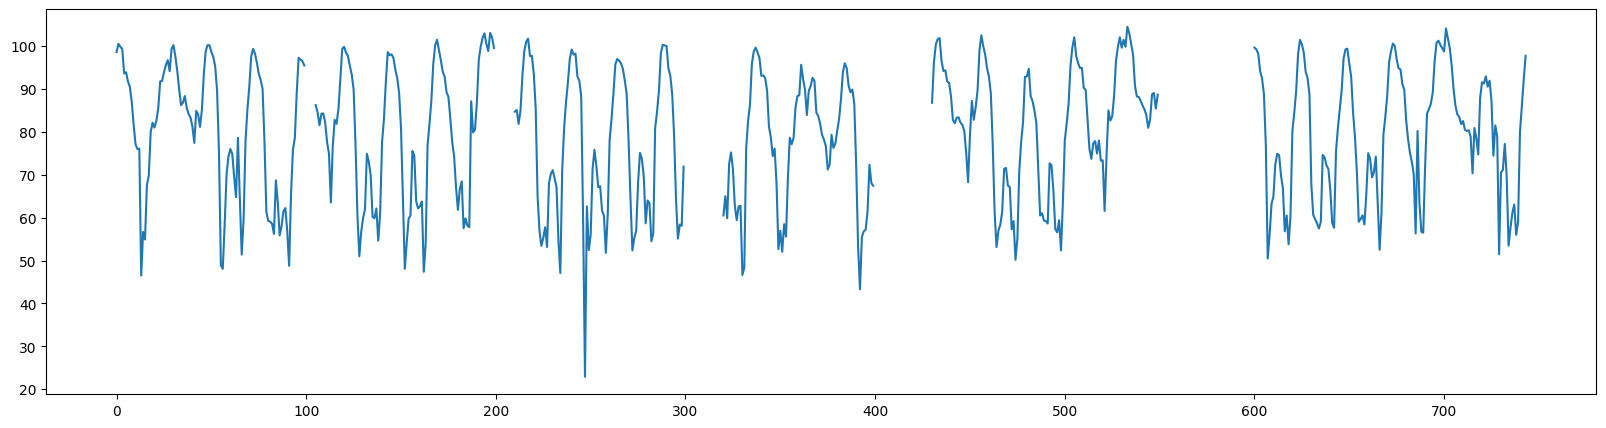

In [2]:
df = pd.read_csv("서인천IC-부평IC 평균속도.csv",encoding='CP949')
df2 = pd.DataFrame()
df2["time"] = pd.to_datetime(df["집계일시"],format="%Y%m%d%H%M")
df2["value"] = df["평균속도"]
missing_range = [(100,105),(200,210),(300,320),(400,430),(550,600)]
for start,end in missing_range:
    df2.iloc[start:end,1] = np.nan
plt.figure(figsize=(20,5))
plt.plot(df2["value"])
plt.show()

In [4]:
df2.to_csv("data.csv", index=False)

In [5]:
def parse_delta(masks, dir_):
    if dir_ == 'backward':
        masks = masks[::-1]

    deltas = []

    for h in range(len(masks)):
        if h == 0:
            deltas.append(1)
        else:
            deltas.append(1 + (1 - masks[h]) * deltas[-1])

    return np.array(deltas)

def parse_delta(masks, dir_):
    if dir_ == 'backward':
        masks = masks[::-1]

    deltas = []

    for h in range(len(masks)):
        if h == 0:
            deltas.append(1)
        else:
            deltas.append(1 + (1 - masks[h]) * deltas[-1])

    return np.array(deltas)

def parse_rec(values, masks, evals, eval_masks, dir_):
    deltas = parse_delta(masks, dir_)

    # only used in GRU-D
    forwards = pd.DataFrame(values).fillna(method='ffill').fillna(0.0).values

    rec = {}

    rec['values'] = np.nan_to_num(values).tolist()
    rec['masks'] = masks.astype('int32').tolist()
    # imputation ground-truth
    rec['evals'] = np.nan_to_num(evals).tolist()
    rec['eval_masks'] = eval_masks.astype('int32').tolist()
    rec['forwards'] = forwards.tolist()
    rec['deltas'] = deltas.tolist()
    return rec

def makedata(datapath):
    df = pd.read_csv(datapath)
    length = len(df)
    # df.columns = ["Time", "Velocity"]
    df = df[["time", "value"]]

    mean = df["value"].mean()
    std = df["value"].std()

    data = df
    evals = []

    for h in range(len(df)):
        evals.append(data["value"].iloc[h])
    evals = (np.array(evals) - mean) / std
    shp = evals.shape

    values = evals.copy()

    masks = ~np.isnan(values)
    eval_masks = (~np.isnan(values)) ^ (~np.isnan(evals))

    masks = masks.reshape(shp)
    eval_masks = eval_masks.reshape(shp)

    label = 0

    rec = {'label': label}


    # prepare the model for both directions
    rec['forward'] = parse_rec(values, masks, evals, eval_masks, dir_='forward')
    rec['backward'] = parse_rec(values[::-1], masks[::-1], evals[::-1], eval_masks[::-1], dir_='backward')

    rec = json.dumps(rec)
    fs = open('./traffic.json', 'w')
    fs.write(rec)    
    fs.close()
    return length

#====================data loader====================
class MySet(Dataset):
    def __init__(self, file):
        super(MySet, self).__init__()
        self.content = open(file).readlines()

        indices = np.arange(len(self.content))
        val_indices = np.random.choice(indices, len(self.content) // 5)

        self.val_indices = set(val_indices.tolist())

    def __len__(self):
        return len(self.content)

    def __getitem__(self, idx):
        rec = json.loads(self.content[idx])
        if idx in self.val_indices:
            rec['is_train'] = 0
        else:
            rec['is_train'] = 1
        return rec

def collate_fn(recs):
    forward = list(map(lambda x: x['forward'], recs))
    backward = list(map(lambda x: x['backward'], recs))

    def to_tensor_dict(recs):
        values = torch.FloatTensor(list(map(lambda r: r['values'], recs))).unsqueeze(-1)
        masks = torch.FloatTensor(list(map(lambda r: r['masks'], recs))).unsqueeze(-1)
        deltas = torch.FloatTensor(list(map(lambda r: r['deltas'], recs))).unsqueeze(-1)

        evals = torch.FloatTensor(list(map(lambda r: r['evals'], recs))).unsqueeze(-1)
        eval_masks = torch.FloatTensor(list(map(lambda r: r['eval_masks'], recs))).unsqueeze(-1)
        forwards = torch.FloatTensor(list(map(lambda r: r['forwards'], recs))).unsqueeze(-1)


        return {'values': values, 'forwards': forwards, 'masks': masks, 'deltas': deltas, 'evals': evals, 'eval_masks': eval_masks}

    ret_dict = {'forward': to_tensor_dict(forward), 'backward': to_tensor_dict(backward)}

    ret_dict['labels'] = torch.FloatTensor(list(map(lambda x: x['label'], recs))).unsqueeze(-1)
    ret_dict['is_train'] = torch.FloatTensor(list(map(lambda x: x['is_train'], recs))).unsqueeze(-1)

    return ret_dict

def get_loader(file, batch_size = 64, shuffle = True):
    data_set = MySet(file)
    data_iter = DataLoader(dataset = data_set, batch_size = batch_size,num_workers = 4, shuffle = shuffle, pin_memory = True, collate_fn = collate_fn)

    return data_iter

# ================util===================
def to_var(var, device):
    if torch.is_tensor(var):
        var = Variable(var)
        # if torch.cuda.is_available():
        var = var.to(device)
        return var
    if isinstance(var, int) or isinstance(var, float) or isinstance(var, str):
        return var
    if isinstance(var, dict):
        for key in var:
            var[key] = to_var(var[key], device)
        return var
    if isinstance(var, list):
        var = map(lambda x: to_var(x, device), var)
        return var

In [6]:
class Brits_i(nn.Module):
    def __init__(self, rnn_hid_size, impute_weight, label_weight, seq_len, device):
        super(Brits_i, self).__init__()

        self.rnn_hid_size = rnn_hid_size
        self.impute_weight = impute_weight
        self.label_weight = label_weight
        self.seq_len = seq_len
        self.device = device

        self.build()

    def build(self):
        self.rits_f = Rits_i(self.rnn_hid_size, self.impute_weight, self.label_weight,self.seq_len, self.device)
        self.rits_b = Rits_i(self.rnn_hid_size, self.impute_weight, self.label_weight,self.seq_len, self.device)

    def forward(self, data):
        ret_f = self.rits_f(data, 'forward')
        ret_b = self.reverse(self.rits_b(data, 'backward'))

        ret = self.merge_ret(ret_f, ret_b)

        return ret

    def merge_ret(self, ret_f, ret_b):
        loss_f = ret_f['loss']
        loss_b = ret_b['loss']
        loss_c = self.get_consistency_loss(ret_f['imputations'], ret_b['imputations'])

        loss = loss_f + loss_b + loss_c

        predictions = (ret_f['predictions'] + ret_b['predictions']) / 2
        imputations = (ret_f['imputations'] + ret_b['imputations']) / 2

        ret_f['loss'] = loss
        ret_f['predictions'] = predictions
        ret_f['imputations'] = imputations

        return ret_f

    def get_consistency_loss(self, pred_f, pred_b):
        loss = torch.abs(pred_f - pred_b).mean() * 1e-1
        return loss

    def reverse(self, ret):
        def reverse_tensor(tensor_):
            if tensor_.dim() <= 1:
                return tensor_
            indices = range(tensor_.size()[1])[::-1]
            indices = Variable(torch.LongTensor(indices), requires_grad = False)

            # if torch.cuda.is_available():
            indices = indices.to(self.device)

            return tensor_.index_select(1, indices)

        for key in ret:
            ret[key] = reverse_tensor(ret[key])

        return ret

    def run_on_batch(self, data, optimizer, epoch=None):
        ret = self(data)

        if optimizer is not None:
            optimizer.zero_grad()
            ret['loss'].backward()
            optimizer.step()

        return ret



#================ritsi=================
def binary_cross_entropy_with_logits(input, target, weight=None, size_average=True, reduce=True):
    if not (target.size() == input.size()):
        raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

    max_val = (-input).clamp(min=0)
    loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

    if weight is not None:
        loss = loss * weight

    if not reduce:
        return loss
    elif size_average:
        return loss.mean()
    else:
        return loss.sum()


class TemporalDecay(nn.Module):
    def __init__(self, input_size, rnn_hid_size):
        super(TemporalDecay, self).__init__()
        self.rnn_hid_size = rnn_hid_size
        self.build(input_size)

    def build(self, input_size):
        self.W = Parameter(torch.Tensor(self.rnn_hid_size, input_size))
        self.b = Parameter(torch.Tensor(self.rnn_hid_size))
        # self.linear = nn.Linear(input_size, self.rnn_hid_size)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.W.size(0))
        self.W.data.uniform_(-stdv, stdv)
        if self.b is not None:
            self.b.data.uniform_(-stdv, stdv)

    def forward(self, d):
        gamma = F.relu(F.linear(d, self.W, self.b))
        gamma = torch.exp(-gamma)
        return gamma

class Rits_i(nn.Module):
    def __init__(self, rnn_hid_size, impute_weight, label_weight, seq_len, device):
        super(Rits_i, self).__init__()

        self.rnn_hid_size = rnn_hid_size
        self.impute_weight = impute_weight
        self.label_weight = label_weight
        self.seq_len = seq_len
        self.device = device

        self.build()

    def build(self):
        self.input_size = 1
        self.rnn_cell = nn.LSTMCell(self.input_size * 2, self.rnn_hid_size)

        self.regression = nn.Linear(self.rnn_hid_size, self.input_size)
        self.temp_decay = TemporalDecay(input_size = self.input_size, rnn_hid_size = self.rnn_hid_size)

        self.out = nn.Linear(self.rnn_hid_size, 1)

    def forward(self, data, direct):
        # Original sequence with 24 time steps
        values = data[direct]['values']
        masks = data[direct]['masks']
        deltas = data[direct]['deltas']

        evals = data[direct]['evals']
        eval_masks = data[direct]['eval_masks']

        labels = data['labels'].view(-1, 1)
        is_train = data['is_train'].view(-1, 1)

        h = Variable(torch.zeros((values.size()[0], self.rnn_hid_size)))
        c = Variable(torch.zeros((values.size()[0], self.rnn_hid_size)))

        # if torch.cuda.is_available():
        #   h,c = h.cuda(), c.cuda()
        h, c = h.to(self.device), c.to(self.device)

        x_loss = 0.0
        y_loss = 0.0

        imputations = []

        for t in range(self.seq_len):
            x = values[:, t, :]
            m = masks[:, t, :]
            d = deltas[:, t, :]
            gamma = self.temp_decay(d)
            h = h * gamma
            x_h = self.regression(h)

            x_c =  m * x +  (1 - m) * x_h

            x_loss += torch.sum(torch.abs(x - x_h) * m) / (torch.sum(m) + 1e-5)

            inputs = torch.cat([x_c, m], dim = 1)

            h, c = self.rnn_cell(inputs, (h, c))

            imputations.append(x_c.unsqueeze(dim = 1))

        imputations = torch.cat(imputations, dim = 1)

        y_h = self.out(h)
        y_loss = binary_cross_entropy_with_logits(y_h, labels, reduce = False)

        # only use training labels
        y_loss = torch.sum(y_loss * is_train) / (torch.sum(is_train) + 1e-5)

        y_h = torch.sigmoid(y_h)

        return {'loss': x_loss * self.impute_weight + y_loss * self.label_weight, 'predictions': y_h,\
                'imputations': imputations, 'labels': labels, 'is_train': is_train,\
                'evals': evals, 'eval_masks': eval_masks}

    def run_on_batch(self, data, optimizer, epoch = None):
        ret = self(data, direct = 'forward')

        if optimizer is not None:
            optimizer.zero_grad()
            ret['loss'].backward()
            optimizer.step()

        return ret

In [7]:
def evaluate():
    model.eval()
    imputations = []
    for idx, data in enumerate(data_iter):
        data = to_var(data, device)
        ret = model.run_on_batch(data, None)
        eval_masks = ret['eval_masks'].data.cpu().numpy()
        imputation = ret['imputations'].data.cpu().numpy()
        imputations += imputation[np.where(eval_masks == 1)].tolist()
    imputations = np.asarray(imputations)
    return imputation

In [8]:
def predict_result():
    imputation  = evaluate()
    scaler = StandardScaler()
    scaler = scaler.fit(df["value"].to_numpy().reshape(-1,1))
    result = scaler.inverse_transform(imputation[0])
    return result[:,0]

In [10]:
import torch_directml

path = "data.csv"
device = torch_directml.device()

df = pd.read_csv(path)
data = df["value"]
length = len(df)

makedata("data.csv")

C:\Users\juh08\AppData\Local\Temp\ipykernel_13780\3023387309.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forwards = pd.DataFrame(values).fillna(method='ffill').fillna(0.0).values


744

In [11]:
epoch = 100
model = Brits_i(108, 1, 0, length, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
data_iter = get_loader('./traffic.json', batch_size=64)

data_iter = get_loader('./traffic.json', batch_size=64)

In [ ]:
for idx, data in enumerate(data_iter): 
    data = to_var(data,device)
    print(data)
    break


In [9]:
epoch = 100
model = Brits_i(108, 1, 0, length, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
data_iter = get_loader('./traffic.json', batch_size=64)

model.train()
progress = tqdm(range(epoch))
for i in progress:
    tl=0.0
    for idx, data in enumerate(data_iter):  
        data = to_var(data,device)
        ret =model.run_on_batch(data,optimizer, i)
        tl += ret["loss"]
    progress.set_description("loss: {:0.3f}".format(tl/len(data_iter)))

loss: 266.085876: 100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


In [10]:
result =predict_result()
real = pd.read_csv("서인천IC-부평IC 평균속도.csv",encoding='CP949')

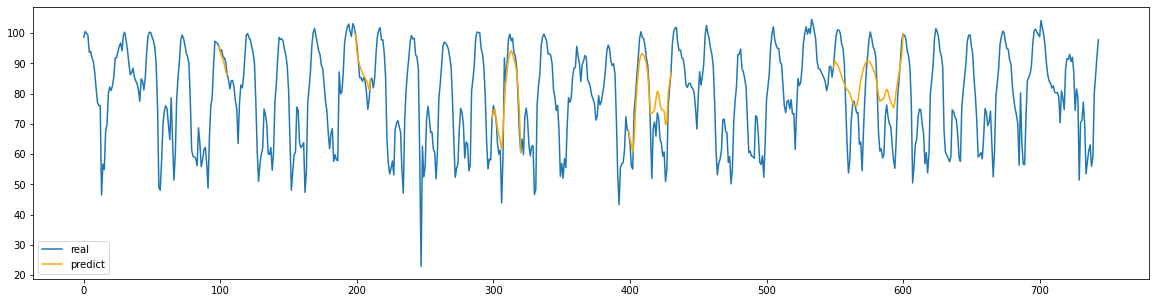

In [11]:
plt.figure(figsize=(20,5))
plt.plot(real["평균속도"], label="real")
lb = "predict"
for start, end in missing_range:
    plt.plot(range(start-1,end+1), result[start-1:end+1], label=lb, color="orange")
    lb=None
plt.legend()
plt.show()

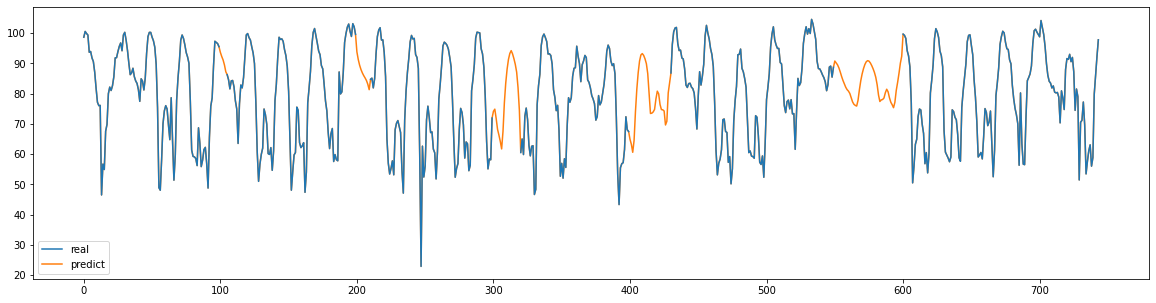

In [12]:
plt.figure(figsize=(20,5))
plt.plot(df["value"], label="real", zorder=10)
plt.plot(result, label="predict")
plt.legend()
plt.show()

In [13]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

realval = real["평균속도"].values
for start,end in missing_range:
    print("길이{}인 구간의 MAPE:{:.3f}".format(end-start, MAPEval(result[start:end], realval[start:end])))

길이5인 구간의 MAPE:1.891
길이10인 구간의 MAPE:3.546
길이20인 구간의 MAPE:7.241
길이30인 구간의 MAPE:11.775
길이50인 구간의 MAPE:15.310
